# Multilayer perceptron in TensorFlow (plain vanilla)

In this script we build a small multilayer perceptron with two hidden layers having 500 and 50 neurons each for classifying the MNIST database of handwritten digits.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import time
import tensorflow as tf
import pandas as pd
tf.set_random_seed(1)
np.random.seed(1)
import sys
tf.__version__, sys.version_info

('1.2.1',
 sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0))

In [3]:
# To be compatible with python3 and python2
try:
    import cPickle as pickle
except ImportError:
    import pickle
import gzip

with gzip.open('../data/mnist_4000.pkl.gz', 'rb') as f:
    if sys.version_info.major > 2:
        (X,y) = pickle.load(f, encoding='latin1')
    else:
        (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])

print(X.shape, y.shape, PIXELS) #As read
# We need to reshape for the MLP
X = X.reshape([4000, 784])
np.shape(X)

(4000, 1, 28, 28) (4000,) 28


(4000, 784)

In [4]:
# Taken from http://stackoverflow.com/questions/29831489/numpy-1-hot-array
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

## Building the network
Build a network with the following architecture.

### Definition of the network (architecture)

* An Input Layer with the following 2-dimensions: 
    * 0: Batch Size yet unkown hence `None`
    * 1: 784 = 28*28 pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units

### Hints
* The weights can be specified and intitialized as
```{python}
    w_1 = tf.Variable(tf.random_normal([784, 500]))
```
* Use ```tf.nn.sigmoid``` activations for the hidden layer

In [5]:
tf.reset_default_graph()
tf.set_random_seed(1)
x = tf.placeholder(tf.float32, shape=[None, 784], name='x_data')
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_data')

# From Input to first hidden layer
w_1 = tf.Variable(tf.random_normal([784, 500], stddev=0.1))
b_1 = tf.Variable(tf.random_normal([500]))
h_1_in = tf.add(tf.matmul(x, w_1), b_1)
h_1_out = tf.nn.relu(h_1_in)

# From first hidden layer to second hidden layer
# <--- Your code here --->
w_2 = tf.Variable(tf.random_normal([500, 50], stddev=0.1))
b_2 = tf.Variable(tf.random_normal([50]))
h_2_in = tf.add(tf.matmul(h_1_out, w_2), b_2)
h_2_out = tf.nn.relu(h_2_in)
# <--- End of your code here --->

# From second hidden layer to output
w_3 = tf.Variable(tf.random_normal([50, 10], stddev=0.1))
b_3 = tf.Variable(tf.random_normal([10]))
h_3_in = tf.add(tf.matmul(h_2_out, w_3), b_3)

# Output is softmax
out = tf.nn.softmax(h_3_in)
init_op = tf.global_variables_initializer() 

### Store the graph and visualize it in tensorflow

In [6]:
tf.summary.FileWriter("/tmp/dumm/mlp_tensorflow_solution/", tf.get_default_graph()).close() #<--- Where to store

### Doing a forward pass of the untrained network
Since we fixed the random seed, you should you should get a result like:

In [7]:
with tf.Session() as sess:
    sess.run(init_op)
    res_val = sess.run(out, feed_dict={x:X[0:2]})
res_val

array([[2.8954923e-01, 6.0280547e-02, 5.3648587e-04, 3.2758262e-02,
        3.4571748e-04, 2.1264413e-01, 1.9114131e-01, 1.5138838e-03,
        1.6557875e-01, 4.5651730e-02],
       [4.1504520e-01, 8.7212622e-02, 2.2648955e-02, 7.1340412e-02,
        6.8323514e-03, 5.7461418e-02, 7.4054010e-02, 1.0842062e-02,
        2.1011850e-01, 4.4444386e-02]], dtype=float32)

### Train the model

In [7]:
loss = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(out), reduction_indices=[1]))
# <---- Your code here (fix the optimzer)
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
init_op = tf.global_variables_initializer() 
vals = []
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(4000):
        idx = np.random.permutation(2400)[0:128] #Easy minibatch of size 128
        loss_, _, res_ = sess.run((loss, train_op,out), feed_dict={x:X[idx], y_true:convertToOneHot(y[idx], 10)})
        if (i % 100 == 0):
            # Get the results for the validation results (from 2400:3000)
            acc = np.average(np.argmax(res_, axis = 1) == y[idx])
            # <---------   Your code here -----------------
            loss_v, res_val = sess.run([loss, out], feed_dict={x:X[2400:3000], y_true:convertToOneHot(y[2400:3000], 10)})
            acc_v = np.average(np.argmax(res_val, axis = 1) == y[2400:3000])
            # <---------  End of your code here
            vals.append([loss_, acc, loss_v, acc_v])
            print("{} Training: loss {} acc {} Validation: loss {} acc {}".format(i, loss_, acc, loss_v, acc_v))

0 Training: loss 3.420847177505493 acc 0.140625 Validation: loss 3.239569664001465 acc 0.09666666666666666
100 Training: loss 0.7122768759727478 acc 0.78125 Validation: loss 0.8066962361335754 acc 0.775
200 Training: loss 0.4015341103076935 acc 0.90625 Validation: loss 0.5736956596374512 acc 0.8316666666666667
300 Training: loss 0.35005760192871094 acc 0.90625 Validation: loss 0.49181559681892395 acc 0.8466666666666667
400 Training: loss 0.24412362277507782 acc 0.9375 Validation: loss 0.4700329601764679 acc 0.8533333333333334
500 Training: loss 0.22291068732738495 acc 0.9296875 Validation: loss 0.4452160596847534 acc 0.8616666666666667
600 Training: loss 0.11122415959835052 acc 0.9921875 Validation: loss 0.4285358190536499 acc 0.8716666666666667
700 Training: loss 0.2019336223602295 acc 0.9609375 Validation: loss 0.42716410756111145 acc 0.8716666666666667
800 Training: loss 0.19144302606582642 acc 0.9765625 Validation: loss 0.4196571707725525 acc 0.88
900 Training: loss 0.1800352931022

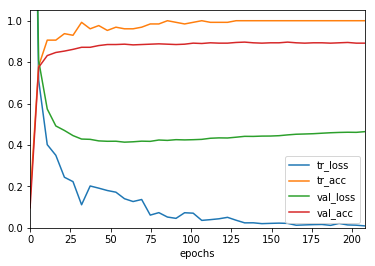

In [8]:
vals_df = pd.DataFrame(vals)
vals_df.columns = ['tr_loss', 'tr_acc', 'val_loss', 'val_acc']
vals_df['epochs'] = (np.asarray(range(len(vals_df))) * 100.0 * 128. / 2400)
vals_df.plot(ylim = (0,1.05), x='epochs')